In [33]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [34]:
data_path = "/kaggle/input/ai-and-real-art-image-dataset/AI_AND_Real_Art" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [35]:
data.head()

,image,label
0,/kaggle/input/ai-and-real-art-image-dataset/AI...,RealArt
1,/kaggle/input/ai-and-real-art-image-dataset/AI...,RealArt
2,/kaggle/input/ai-and-real-art-image-dataset/AI...,RealArt
3,/kaggle/input/ai-and-real-art-image-dataset/AI...,RealArt
4,/kaggle/input/ai-and-real-art-image-dataset/AI...,RealArt


In [36]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()  


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 775 validated image filenames belonging to 2 classes.
Found 97 validated image filenames belonging to 2 classes.
Found 98 validated image filenames belonging to 2 classes.


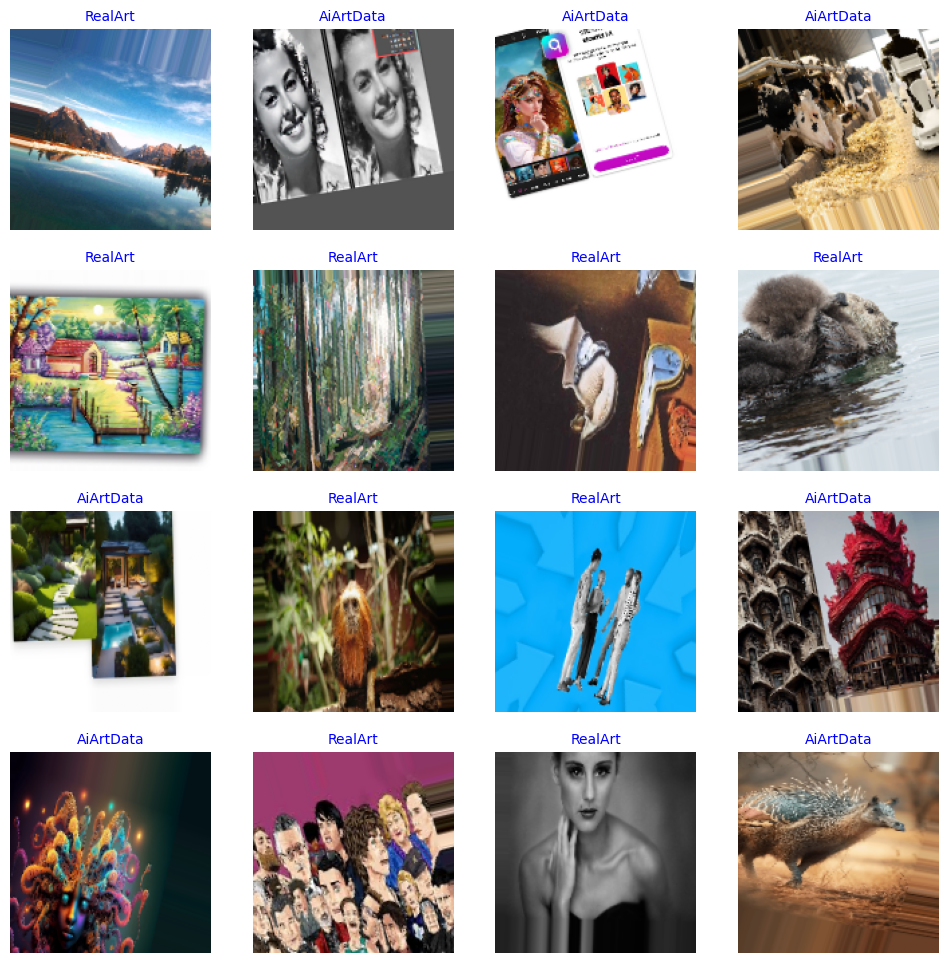

In [38]:
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [39]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")
            self.model.stop_training = True

In [40]:
from tensorflow.keras.layers import BatchNormalization


n_classes = 2
input_shape = (150, 150, 3)

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,858 (2.46 MB)

 Trainable params: 645,154 (2.46 MB)

 Non-trainable params: 704 (2.75 KB)

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler


def lr_scheduler(epoch, lr):
    new_lr = lr * tf.math.exp(-0.1)
    return float(new_lr.numpy())


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.0001
)

callbacks = [
    myCallback(),
    LearningRateScheduler(lr_scheduler),
    reduce_lr
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=20,
    batch_size=32,
    verbose=2,
    validation_data=valid_gen,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1731047471.896124     119 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1731047482.664275     120 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads



Epoch 1: Training accuracy is 0.5445
Epoch 1: Validation accuracy is 0.4536
25/25 - 32s - 1s/step - accuracy: 0.5445 - loss: 9.9921 - val_accuracy: 0.4536 - val_loss: 372.1768 - learning_rate: 0.0090
Epoch 2/20
Epoch 2: Training accuracy is 0.5394
Epoch 2: Validation accuracy is 0.5567
25/25 - 23s - 919ms/step - accuracy: 0.5394 - loss: 6.5165 - val_accuracy: 0.5567 - val_loss: 20.9024 - learning_rate: 0.0082
Epoch 3/20
Epoch 3: Training accuracy is 0.5716
Epoch 3: Validation accuracy is 0.4433
25/25 - 23s - 910ms/step - accuracy: 0.5716 - loss: 3.6496 - val_accuracy: 0.4433 - val_loss: 4.3230 - learning_rate: 0.0074
Epoch 4/20
Epoch 4: Training accuracy is 0.5884
Epoch 4: Validation accuracy is 0.5567
25/25 - 23s - 926ms/step - accuracy: 0.5884 - loss: 2.1611 - val_accuracy: 0.5567 - val_loss: 3.5431 - learning_rate: 0.0067
Epoch 5/20
Epoch 5: Training accuracy is 0.5923
Epoch 5: Validation accuracy is 0.5670
25/25 - 23s - 915ms/step - accuracy: 0.5923 - loss: 1.4940 - val_accuracy: 0

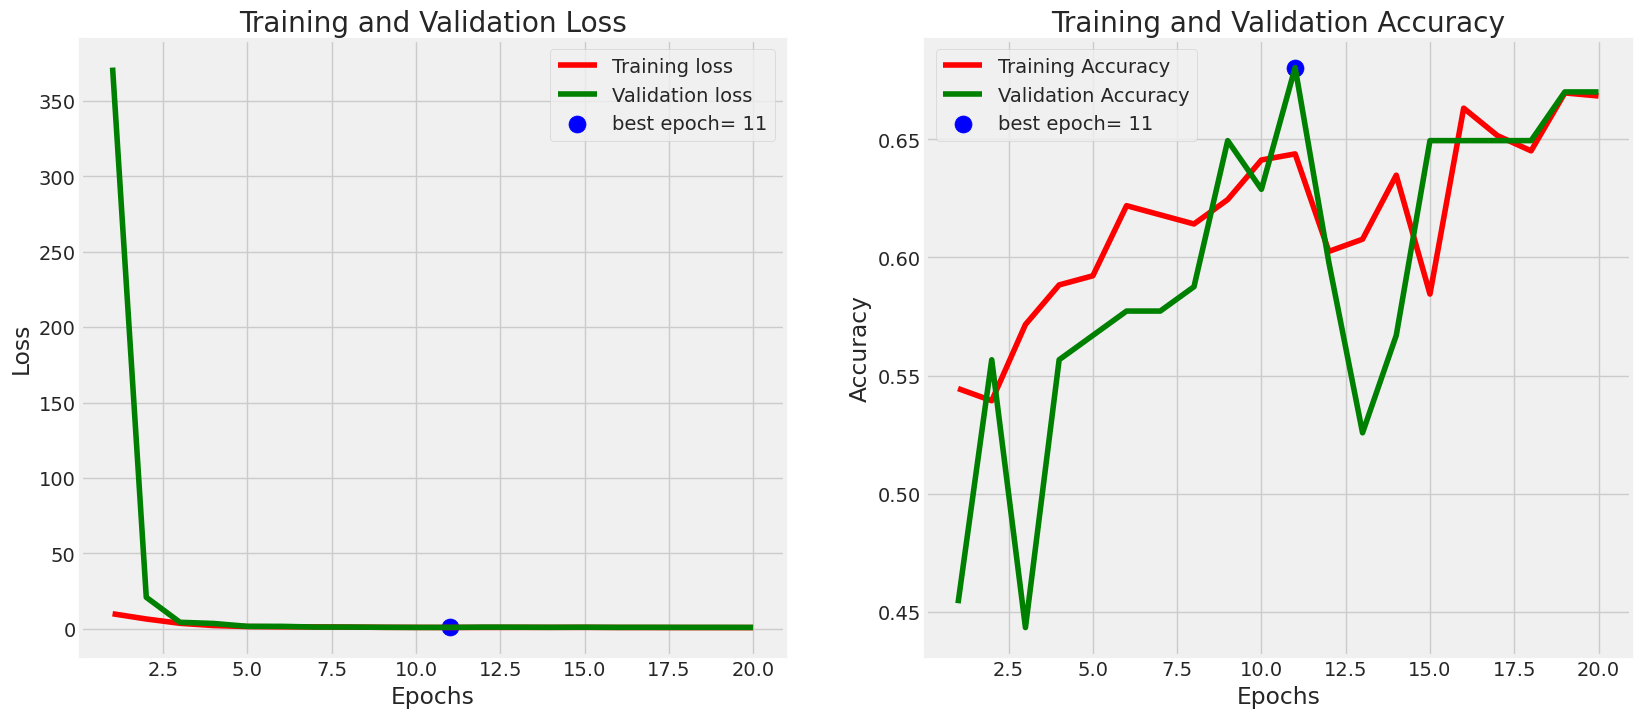

In [42]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout

plt.savefig('training_validation_plots.png')
plt.show()


In [43]:
model.save('model_2.h5')


In [44]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.6347 - loss: 0.9699
Accuracy score: 0.6701030731201172


In [45]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 766ms/step - accuracy: 0.7264 - loss: 0.8446
Test accuracy: 0.7041
Test loss: 0.8919


In [46]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 710ms/step - accuracy: 0.6771 - loss: 0.7873
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - accuracy: 0.5833 - loss: 1.0173
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 724ms/step - accuracy: 0.7396 - loss: 0.8067
Train Loss:  0.7884038686752319
Train Accuracy:  0.671875
--------------------
Valid Loss:  1.0264525413513184
Valid Accuracy:  0.59375
--------------------
Test Loss:  0.8787169456481934
Test Accuracy:  0.703125


In [47]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step


In [48]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


              precision    recall  f1-score   support

   AiArtData       0.69      0.83      0.76        54
     RealArt       0.73      0.55      0.62        44

    accuracy                           0.70        98
   macro avg       0.71      0.69      0.69        98
weighted avg       0.71      0.70      0.70        98



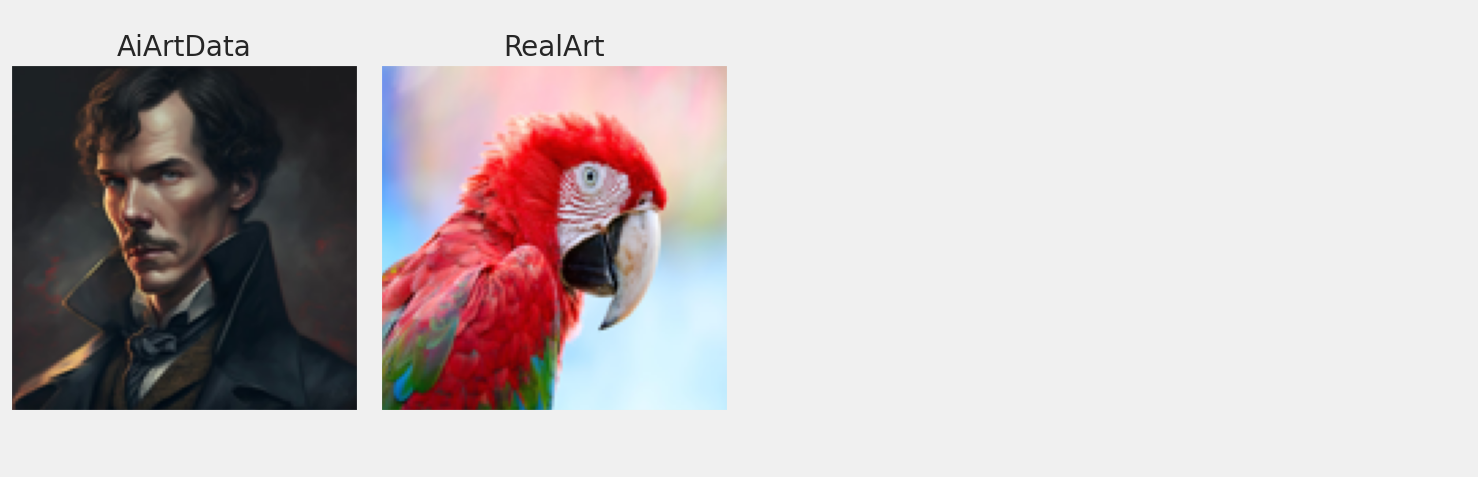

In [49]:
import matplotlib.pyplot as plt
from PIL import Image

class_samples = []

for label in test_df['label'].unique():
    sample = test_df[test_df['label'] == label].iloc[0]  
    class_samples.append((sample['image'], sample['label']))

target_size = (128, 128)  

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (filepath, label) in zip(axes, class_samples):
    img = Image.open(filepath)
    img_resized = img.resize(target_size)
    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('Display_images.jpg', dpi=1200)
plt.show()

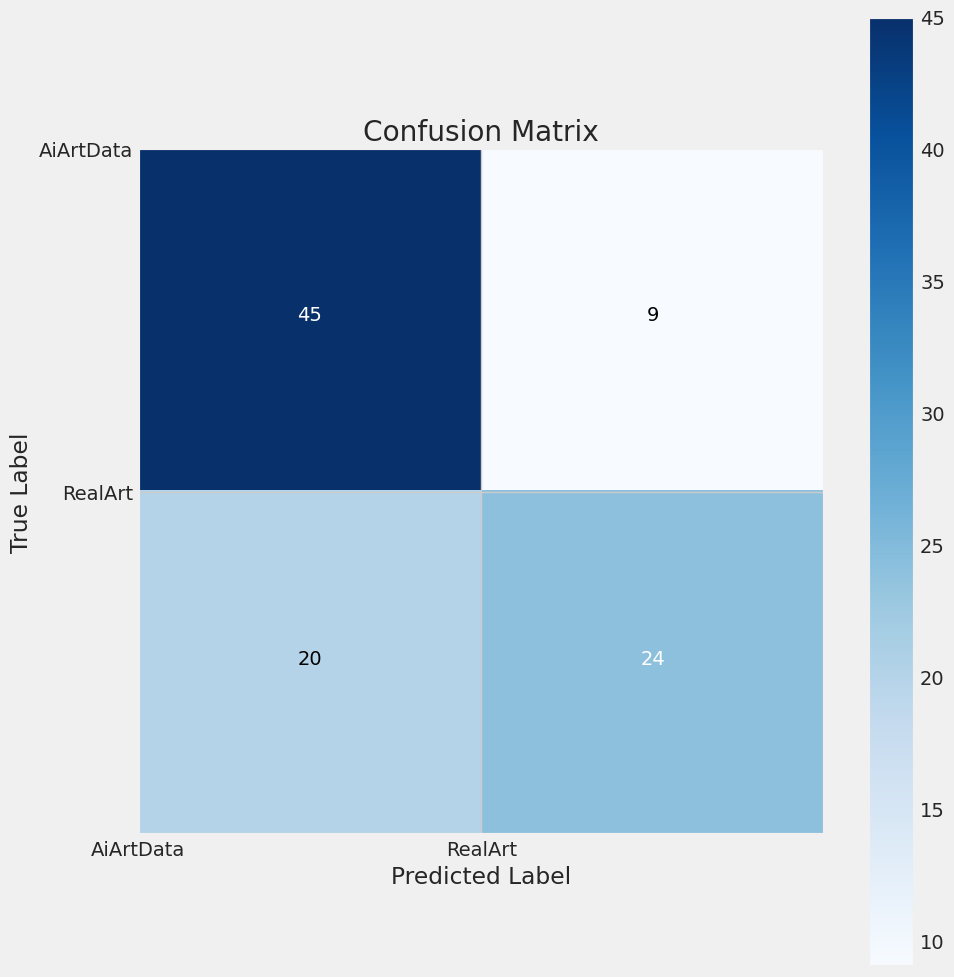

In [50]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

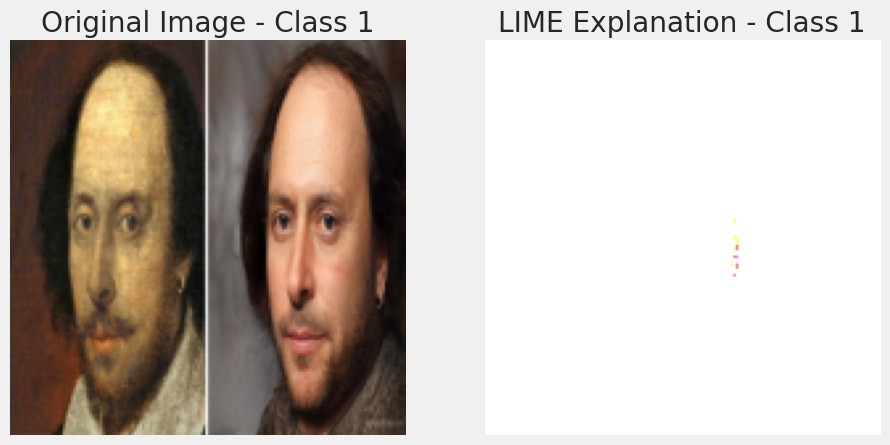

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

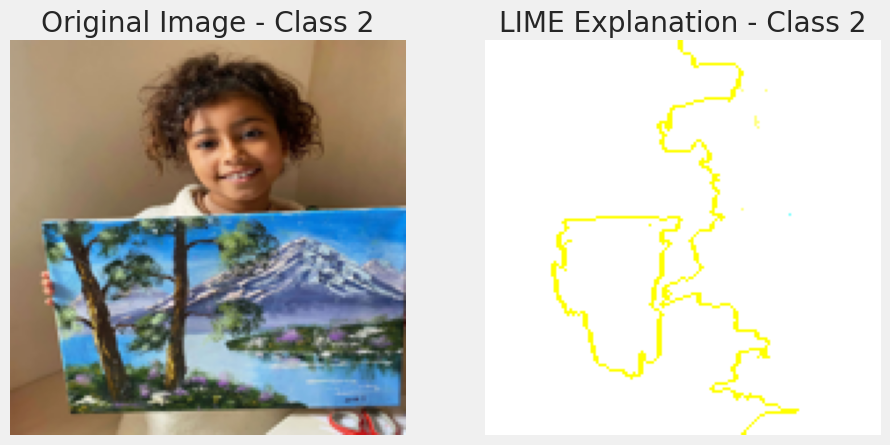

In [51]:
import lime
import lime.lime_image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.segmentation import mark_boundaries
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model = load_model('/kaggle/working/model_2.h5')

# Initialize the LIME explainer
explainer = lime.lime_image.LimeImageExplainer()

# List of image paths, one for each class
image_paths = [
    '/kaggle/input/ai-and-real-art-image-dataset/AI_AND_Real_Art/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg',
    '/kaggle/input/ai-and-real-art-image-dataset/AI_AND_Real_Art/RealArt/-Skills-Promo-A-Total-Artist-All-of-North-Wests-Impressive-Drawings-Photos-5.jpg',

    
]

# Function to preprocess images for prediction
def predict_fn(images):
    # Resize each image to 100x100, preprocess, and flatten
    processed_images = np.array([preprocess_input(np.array(img).reshape(150, 150, 3)) for img in images])
    return model.predict(processed_images)

# Loop over each class image, generate LIME explanation, and plot the result
for i, img_path in enumerate(image_paths):
    # Load and preprocess the image to keep it in RGB format for LIME
    img = Image.open(img_path).resize((150, 150)).convert('RGB')
    img_np = np.array(img)  # Keep in (100, 100, 3) shape for LIME
    
    # Generate the explanation using RGB image format
    explanation = explainer.explain_instance(img_np, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
    
    # Get the LIME image and mask
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    
    # Display original and LIME image side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    axes[0].imshow(np.array(img).reshape(150, 150, 3))
    axes[0].axis('off')
    axes[0].set_title(f'Original Image - Class {i+1}')
    
    # LIME Explanation Image
    axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axes[1].axis('off')
    axes[1].set_title(f'LIME Explanation - Class {i+1}')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━

  0%|          | 0/7998 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [01:02, 62.44s/it]               


<Figure size 600x600 with 0 Axes>

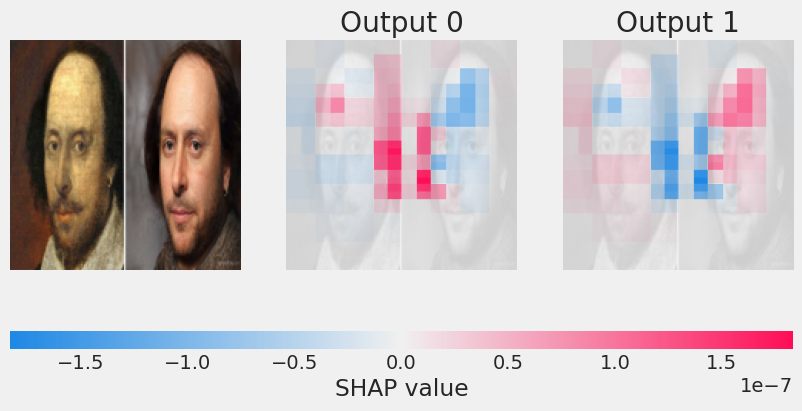

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

  0%|          | 0/7998 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

PartitionExplainer explainer: 2it [00:57, 57.65s/it]               


<Figure size 600x600 with 0 Axes>

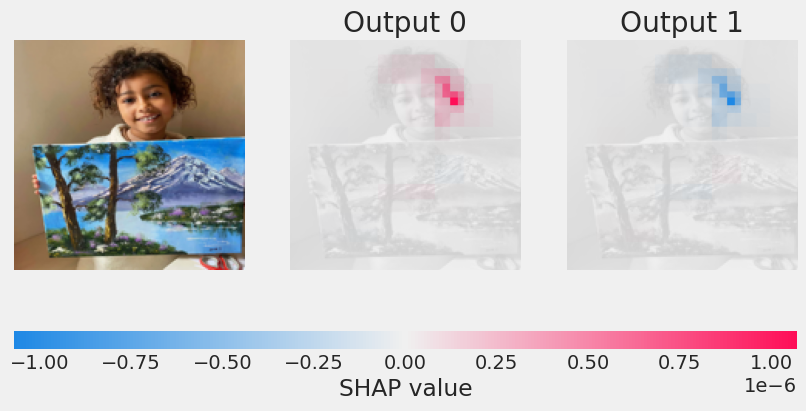

In [52]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

model = load_model('/kaggle/working/model_2.h5')

image_paths = [
    '/kaggle/input/ai-and-real-art-image-dataset/AI_AND_Real_Art/AiArtData/-how-important-people-from-the-past-really-looked-11-Pics-5ffd5c0f4d77f__880.jpg',
    '/kaggle/input/ai-and-real-art-image-dataset/AI_AND_Real_Art/RealArt/-Skills-Promo-A-Total-Artist-All-of-North-Wests-Impressive-Drawings-Photos-5.jpg',

    
]


def preprocess_image(image_path):
    img = Image.open(image_path).resize((150, 150)).convert('RGB')
    img = np.array(img, dtype=np.float32) / 255.0  
    return img

def f(x):
    return model.predict(x)

masker_blur = shap.maskers.Image("blur(100,100)", shape=(150, 150, 3))
explainer = shap.Explainer(f, masker_blur)

for i, img_path in enumerate(image_paths):
    image = preprocess_image(img_path)
    
    shap_values = explainer(image[np.newaxis, :, :, :], max_evals=8000, outputs=shap.Explanation.argsort.flip[:8])
    
    fig = plt.figure(figsize=(6, 6))
    shap.image_plot(shap_values, show=False)
    fig.savefig(f"shap_hieroglyph_{i+1}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [53]:
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Set the input shape to (100, 100, 3) to match the generator output
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet_base.trainable = False

inputs = Input(shape=(150, 150, 3))
x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.fit(train_gen, epochs=10, validation_data=valid_gen)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5284 - loss: 1.7778 - val_accuracy: 0.7320 - val_loss: 0.5334
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - accuracy: 0.6848 - loss: 0.6112 - val_accuracy: 0.7629 - val_loss: 0.4857
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.7279 - loss: 0.5081 - val_accuracy: 0.8041 - val_loss: 0.4467
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 673ms/step - accuracy: 0.7476 - loss: 0.4995 - val_accuracy: 0.7113 - val_loss: 0.5174
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 668ms/step - accuracy: 0.7747 - loss: 0.4542 - val_accuracy: 0.8454 - val_loss: 0.4379
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 657ms/step - accuracy: 0.7830 - loss: 0.4257 - val_accuracy: 0.8660 - val_loss: 0.3862
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 664ms/step - accuracy: 0.8001 - loss: 0.4299 - val_accuracy: 0.8557 - val_loss: 0.3536
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 701ms/s

In [54]:
test_loss, test_acc = resnet_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.7346938848495483   loss:  0.6535695791244507


In [56]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16_base.trainable = False

inputs = Input(shape=(150, 150, 3))

x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
vgg16_model = Model(inputs, outputs)

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.fit(train_gen, epochs=10, validation_data=valid_gen)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 768ms/step - accuracy: 0.5300 - loss: 4.8153 - val_accuracy: 0.7629 - val_loss: 1.7557
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 700ms/step - accuracy: 0.6667 - loss: 2.3106 - val_accuracy: 0.7835 - val_loss: 1.0862
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 623ms/step - accuracy: 0.7140 - loss: 1.3717 - val_accuracy: 0.7629 - val_loss: 0.7826
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 697ms/step - accuracy: 0.7418 - loss: 0.9899 - val_accuracy: 0.8041 - val_loss: 0.6723
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 720ms/step - accuracy: 0.7292 - loss: 0.8864 - val_accuracy: 0.8144 - val_loss: 0.5958
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 703ms/step - accuracy: 0.7583 - loss: 0.6995 - val_accuracy: 0.8041 - val_loss: 0.5342
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 683ms/step - accuracy: 0.7744 - loss: 0.5650 - val_accuracy: 0.8041 - val_loss: 0.4576
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 669ms/step - accuracy: 0.7283 - loss: 0.6028 - val_accu

In [57]:
test_loss, test_acc = vgg16_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.6836734414100647   loss:  0.804358959197998


In [58]:
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
mobilenetv2_base.trainable = False

inputs = Input(shape=(150, 150, 3))

x = mobilenetv2_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
mobilenetv2_model = Model(inputs, outputs)

mobilenetv2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenetv2_model.fit(train_gen, epochs=10, validation_data=valid_gen)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 947ms/step - accuracy: 0.5198 - loss: 1.0213 - val_accuracy: 0.6598 - val_loss: 0.6084
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 645ms/step - accuracy: 0.5633 - loss: 0.7236 - val_accuracy: 0.6392 - val_loss: 0.6093
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 651ms/step - accuracy: 0.5829 - loss: 0.6775 - val_accuracy: 0.6907 - val_loss: 0.6061
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.6489 - loss: 0.6410 - val_accuracy: 0.6598 - val_loss: 0.5983
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 614ms/step - accuracy: 0.6481 - loss: 0.6415 - val_accuracy: 0.6907 - val_loss: 0.5846
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 698ms/step - accuracy: 0.6071 - loss: 0.6423 - val_accuracy: 0.7010 - val_loss: 0.5965
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 653ms/step - accuracy: 0.6089 - loss: 0.6498 - val_accuracy: 0.7113 - val_loss: 0.5853
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 621ms/

In [59]:
test_loss, test_acc = mobilenetv2_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.6224489808082581   loss:  0.6303595304489136


In [60]:
from keras.applications import DenseNet121
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

densenet121_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
densenet121_base.trainable = False

inputs = Input(shape=(150, 150, 3))

x = densenet121_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)
densenet121_model = Model(inputs, outputs)

densenet121_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet121_model.fit(train_gen, epochs=10, validation_data=valid_gen)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5598 - loss: 4.8162 - val_accuracy: 0.6392 - val_loss: 1.1573
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 46s 701ms/step - accuracy: 0.5547 - loss: 2.2453 - val_accuracy: 0.5670 - val_loss: 1.7298
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 669ms/step - accuracy: 0.5671 - loss: 1.2686 - val_accuracy: 0.6598 - val_loss: 0.6470
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 714ms/step - accuracy: 0.6054 - loss: 0.7263 - val_accuracy: 0.6804 - val_loss: 0.5983
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step - accuracy: 0.6547 - loss: 0.6616 - val_accuracy: 0.7216 - val_loss: 0.5888
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 628ms/step - accuracy: 0.6347 - loss: 0.6267 - val_accuracy: 0.7629 - val_loss: 0.5578
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 649ms/step - accuracy: 0.6176 - loss: 0.6773 - val_accuracy: 0.7320 - val_loss: 0.5958
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 689ms/s

In [61]:
test_loss, test_acc = densenet121_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.6428571343421936   loss:  0.6429019570350647


In [62]:
from tensorflow.keras.applications import InceptionV3

base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def build_inceptionv3_model():
    x = base_model_inceptionv3.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)  

    model = Model(inputs=base_model_inceptionv3.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def train_and_evaluate_inceptionv3(train_gen, valid_gen):
    print("Training InceptionV3...")
    
    model = build_inceptionv3_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('inceptionv3_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history = model.fit(
        train_gen,
        epochs=10,  
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model.evaluate(valid_gen)
    print(f"InceptionV3 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"InceptionV3 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_inceptionv3(train_gen, valid_gen)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training InceptionV3...
Epoch 1/10
 1/25 ━━━━━━━━━━━━━━━━━━━━ 28:26 71s/step - accuracy: 0.5000 - loss: 0.7392

I0000 00:00:1731049909.878783     122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_94', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_90', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_84', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_82', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_79', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_74', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_70', 4 by

22/25 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5838 - loss: 0.6764   

I0000 00:00:1731049947.713775     122 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_85', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_84', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_83', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_82', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_80', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_75', 4 byt

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5893 - loss: 0.6753
Epoch 1: val_loss improved from inf to 1.08614, saving model to inceptionv3_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5911 - loss: 0.6747 - val_accuracy: 0.5258 - val_loss: 1.0861 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7444 - loss: 0.5085
Epoch 2: val_loss improved from 1.08614 to 0.91983, saving model to inceptionv3_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 809ms/step - accuracy: 0.7457 - loss: 0.5070 - val_accuracy: 0.6495 - val_loss: 0.9198 - learning_rate: 1.0000e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8439 - loss: 0.3725
Epoch 3: val_loss did not improve from 0.91983
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 740ms/step - accuracy: 0.8435 - loss: 0.3727 - val_accuracy: 0.6186 - val_loss: 1.7849 - learning_rate: 1.0000e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.8907 - loss: 0.30

In [63]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


base_model_efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def build_efficientnetb0_model():
    x = base_model_efficientnetb0.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)

    model_efficientnetb0 = Model(inputs=base_model_efficientnetb0.input, outputs=output)
    model_efficientnetb0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
    return model_efficientnetb0

def train_and_evaluate_efficientnetb0(train_gen, valid_gen):
    print("Training EfficientNetB0...")
    
    model_efficientnetb0 = build_efficientnetb0_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('efficientnetb0_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_efficientnetb0 = model_efficientnetb0.fit(
        train_gen,
        epochs=20,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_efficientnetb0.evaluate(valid_gen)
    print(f"EfficientNetB0 Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_efficientnetb0.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"EfficientNetB0 Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_efficientnetb0(train_gen, valid_gen)

Training EfficientNetB0...
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5523 - loss: 0.7199
Epoch 1: val_loss improved from inf to 0.59271, saving model to efficientnetb0_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.5543 - loss: 0.7183 - val_accuracy: 0.6907 - val_loss: 0.5927 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7334 - loss: 0.5529
Epoch 2: val_loss improved from 0.59271 to 0.49519, saving model to efficientnetb0_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 742ms/step - accuracy: 0.7345 - loss: 0.5515 - val_accuracy: 0.7835 - val_loss: 0.4952 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8401 - loss: 0.4372
Epoch 3: val_loss improved from 0.49519 to 0.43326, saving model to efficientnetb0_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 708ms/step - accuracy: 0.8396 - loss: 0.4372 - val_accuracy: 0.8454 - val_loss: 0.4333 - learning_rat

In [67]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def build_model():
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('efficientnetb0_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)


In [68]:
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4746 - loss: 0.7646
Epoch 1: val_loss improved from inf to 0.71510, saving model to efficientnetb0_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4758 - loss: 0.7630 - val_accuracy: 0.5876 - val_loss: 0.7151 - learning_rate: 1.0000e-04
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7013 - loss: 0.5639
Epoch 2: val_loss improved from 0.71510 to 0.60488, saving model to efficientnetb0_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 723ms/step - accuracy: 0.7024 - loss: 0.5628 - val_accuracy: 0.6804 - val_loss: 0.6049 - learning_rate: 1.0000e-04
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8166 - loss: 0.4401
Epoch 3: val_loss improved from 0.60488 to 0.51716, saving model to efficientnetb0_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 760ms/step - accuracy: 0.8165 - loss: 0.4401 - val_accuracy: 0.7320 - val_loss: 0.5172 - learning_rate: 1.0000e-04
Epoch 4/20
25

In [69]:
model.save('efficientnetb0_model.h5')

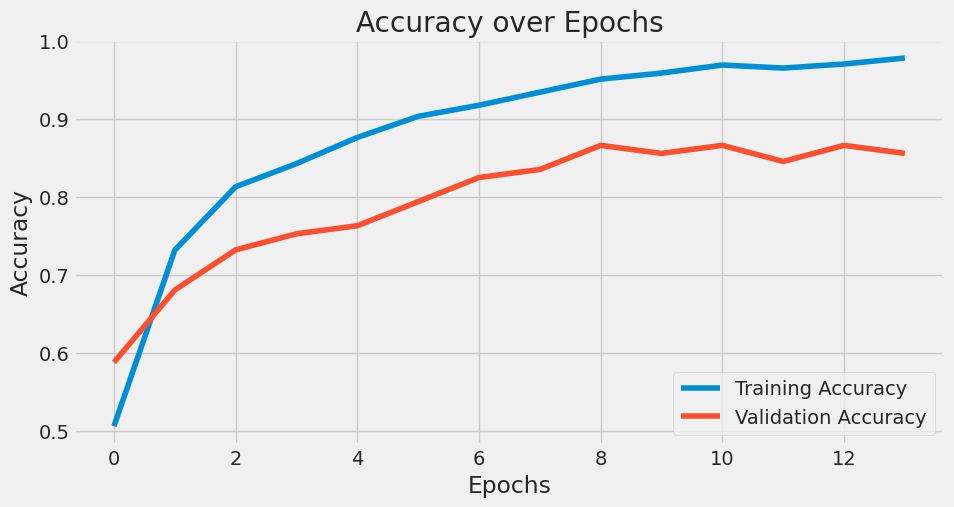

In [70]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

plot_accuracy(history)


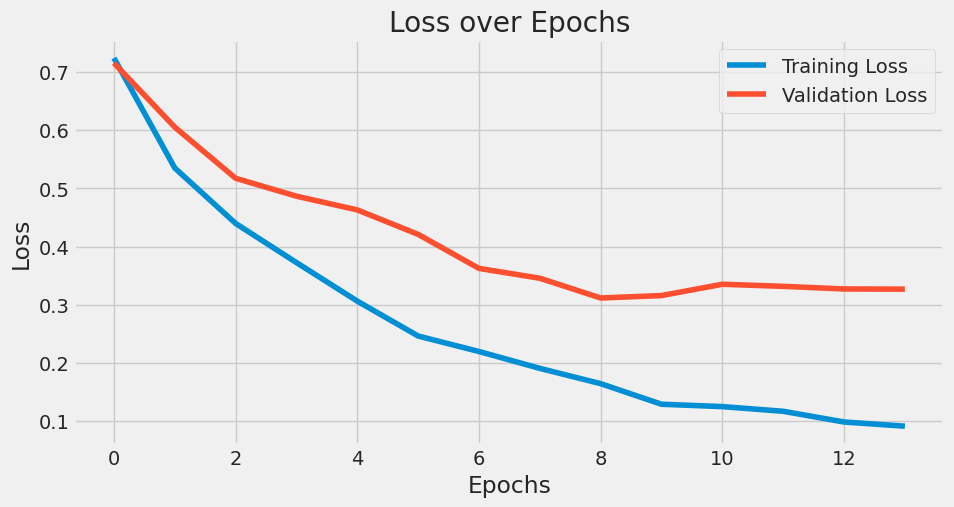

In [71]:
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)


In [72]:
train_loss, train_accuracy = model.evaluate(train_gen)
val_loss, val_accuracy = model.evaluate(valid_gen)
test_loss, test_accuracy = model.evaluate(test_gen)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 937ms/step - accuracy: 0.9809 - loss: 0.1013
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.8808 - loss: 0.3076
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7923 - loss: 0.4637  
Training Accuracy: 0.9742
Validation Accuracy: 0.8660
Test Accuracy: 0.7959


In [73]:
from sklearn.metrics import classification_report
import numpy as np

val_predictions = model.predict(valid_gen)
val_predictions_classes = np.argmax(val_predictions, axis=1)
val_true_labels = valid_gen.classes

print("Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step  
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87        54
           1       0.81      0.91      0.86        43

    accuracy                           0.87        97
   macro avg       0.87      0.87      0.87        97
weighted avg       0.87      0.87      0.87        97



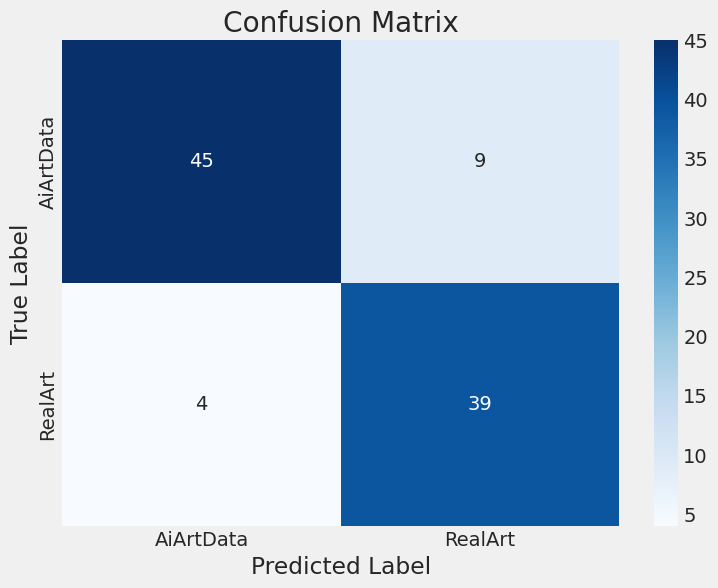

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(val_true_labels, val_predictions_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=valid_gen.class_indices, yticklabels=valid_gen.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


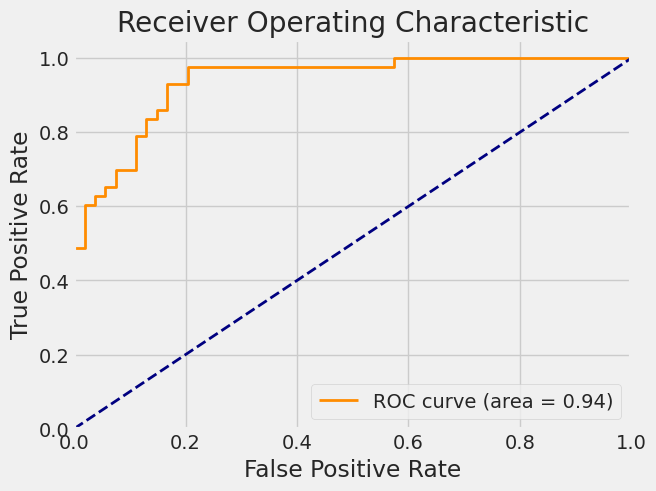

In [75]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

val_labels_binarized = label_binarize(val_true_labels, classes=[0, 1])
fpr, tpr, _ = roc_curve(val_labels_binarized, val_predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


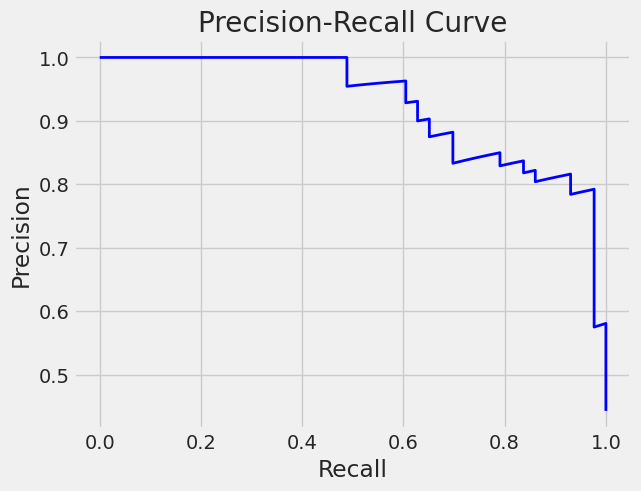

In [76]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(val_labels_binarized, val_predictions[:, 1])
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [64]:
from tensorflow.keras.applications import Xception

base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

def build_xception_model():
    x = base_model_xception.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(2, activation='softmax')(x)

    model_xception = Model(inputs=base_model_xception.input, outputs=output)
    model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    return model_xception

def train_and_evaluate_xception(train_gen, valid_gen):
    print("Training Xception...")
    
    model_xception = build_xception_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('xception_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    history_xception = model_xception.fit(
        train_gen,
        epochs=10,
        validation_data=valid_gen,
        callbacks=[early_stopping, checkpoint, reduce_lr]
    )

    val_loss, val_accuracy = model_xception.evaluate(valid_gen)
    print(f"Xception Validation Accuracy: {val_accuracy:.4f}")

    val_predictions = model_xception.predict(valid_gen)
    val_predictions_classes = np.argmax(val_predictions, axis=1)

    val_true_labels = valid_gen.classes

    print(f"Xception Classification Report:\n", classification_report(val_true_labels, val_predictions_classes))

train_and_evaluate_xception(train_gen, valid_gen)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Xception...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5515 - loss: 0.6947
Epoch 1: val_loss improved from inf to 0.89151, saving model to xception_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5544 - loss: 0.6926 - val_accuracy: 0.5979 - val_loss: 0.8915 - learning_rate: 1.0000e-04
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.7850 - loss: 0.4804
Epoch 2: val_loss improved from 0.89151 to 0.75827, saving model to xception_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 693ms/step - accuracy: 0.7857 - loss: 0.4794 - val_accuracy: 0.6907 - val_loss: 0.7583 - learning_rate: 1.0000e-04
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8691 - loss: 0.3472
Epoch 3: val_loss improved from 0.75827 to 0.70635, saving model to xception_best_model.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 769ms/step - accuracy: 0.8690 - loss: 0.3471 - val_accuracy: 0.7526 - val_l